# Cool Star RV Precision
This notebook is designed to test the APOGEE instruments RV precision for cools stars. Of particular interest to Milky Way Mapper's SRD are Red Giants, subgiants, and M dwarfs. This is part of answering Jira Ticket: https://jira.sdss.org/browse/COMMWM-31

In [1]:
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table,vstack
import astropy.units as u
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import matplotlib as mpl
import os.path as path
import numpy as np
from numpy.polynomial import polynomial as P
%matplotlib inline

## Load Daily Reductions

In [2]:
allStar_tab = Table.read('allStar-daily-apo25m.fits')
allStar_tab

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes96,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39
1618,2M21241108+0023308,apStar-daily-apo25m-2M21241108+0023308-59159.fits,apogee/spectro/redux/daily/stars/apo25m/97/97480/apStar-daily-apo25m-2M21241108+0023308-59159.fits,59159,59159,59159,apo25m,daily,97480,0.0,321.04593,0.3909809,53.05351280485398,-33.167238075726566,12.12,0.023,11.537,0.023,11.304,0.021,,-60.509,-220.049,,0,0,0,0,0,0,4376582145,2690938233764582656,20.2725,0.0834379,-60.5094,0.0906221,-220.049,0.0792318,14.8548,0.000557,16.2632,0.004615,13.6917,0.00136,128,mwm_snc_100pc,MWM_SNC_100PC,1,1,1,2052,"BRIGHT_NEIGHBOR,PERSIST_LOW",0,,30.28239,0.0,0.18429226,0.18429226,1.571745,3763.678,18.377628,4.3854876,0.05833076,-1.9674665,0.05243584,nan,nan,1,295.0,0.0,2020-11-07 02:19:55.794551-07
1678,2M21261537-0024200,apStar-daily-apo25m-2M21261537-0024200-59159.fits,apogee/spectro/redux/daily/stars/apo25m/99/99529/apStar-daily-apo25m-2M21261537-0024200-59159.fits,59159,59159,59159,apo25m,daily,99529,0.0,321.56401,-0.4056365,52.59353904643508,-34.03685586210795,10.792,0.026,10.126,0.026,9.998,0.019,,-0.59,-3.628,,0,0,0,0,0,0,4367804592,2687626225567929088,0.189265,0.0379153,-0.590273,0.0651367,-3.62772,0.06411,12.6716,0.000348,13.3485,0.003389,11.8954,0.001421,8388608,mwm_tessrgb_core,MWM_TESSRGB,1,1,1,1048576,RV_SUSPECT,0,,-61.26199,0.0,0.0384314,0.0384314,4.3960505,4459.9834,7.8395667,2.9814246,0.02918164,-1.161864,0.009674512,nan,nan,1,182.0,0.0,2020-11-07 02:26:30.500618-07
1735,2M21281151-0016118,apStar-daily-apo25m-2M21281151-0016118-59159.fits,apogee/spectro/redux/daily/stars/apo25m/99/99018/apStar-daily-apo25m-2M21281151-0016118-59159.fits,59159,59159,59159,apo25m,daily,99018,0.0,322.04797,-0.269952,53.05111720459024,-34.36761438361869,8.736,0.023,8.482,0.029,8.448,0.021,,-15.894,-8.581,,0,0,0,0,0,0,0,2687655156468282112,4.67141,0.0665871,-15.8935,0.0824865,-8.58075,0.0812393,9.6593,0.005308,9.92235,0.015016,9.25465,0.017866,2,None,MWM_TELLURIC,1,1,1,3145728,"RV_SUSPECT,MULTIPLE_SUSPECT",0,,-48.64175,0.0,0.088617235,0.088617235,5.7514124,5847.032,20.018637,4.5242686,0.021310525,-1.227875,0.011583159,nan,nan,2,196.0,0.0,2020-11-07 02:31:44.800195-07
8944,2M00355216+0137248,,,59167,59167,59167,apo25m,daily,95501,0.0,8.967351,1.623559,114.88546952524845,-61.00467158261487,8.898,0.029,8.723,0.042,8.684,0.023,,-11.49,-2.225,,0,0,0,0,0,0,0,0,3.44975,0.0731237,-11.4896,0.160375,-2.22453,0.104461,9.47132,0.000257,9.66453,0.000852,9.1767,0.000698,2,None,MWM_TELLURIC,1,1,0,524288,RV_REJECT,0,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,161.0,0.0,2020-11-14 18:27:05.05528-07
8948,2M00364129+0055207,,,59167,59167,59167,apo25m,daily,96525,0.0,9.1726114,0.9217714,115.13072964722758,-61.726340485623965,13.886,0.032,13.303,0.025,12.956,0.029,,129.147,-162.502,,0,0,0,0,0,0,4399286

In [3]:
allStar_tab.columns

<TableColumns names=('pk','apogee_id','file','uri','starver','mjdbeg','mjdend','telescope','apred_vers','healpix','snr','ra','dec','glon','glat','jmag','jerr','hmag','herr','kmag','kerr','src_h','targ_pmra','targ_pmdec','targ_pm_src','apogee_target1','apogee_target2','apogee2_target1','apogee2_target2','apogee2_target3','apogee2_target4','catalogid','gaiadr2_sourceid','gaiadr2_plx','gaiadr2_plx_error','gaiadr2_pmra','gaiadr2_pmra_error','gaiadr2_pmdec','gaiadr2_pmdec_error','gaiadr2_gmag','gaiadr2_gerr','gaiadr2_bpmag','gaiadr2_bperr','gaiadr2_rpmag','gaiadr2_rperr','sdssv_apogee_target0','firstcarton','targflags','nvisits','ngoodvisits','ngoodrvs','starflag','starflags','andflag','andflags','vheliobary','vscatter','verr','vmederr','chisq','rv_teff','rv_tefferr','rv_logg','rv_loggerr','rv_feh','rv_feherr','rv_ccpfwhm','rv_autofwhm','n_components','meanfib','sigfib','created')>

In [4]:
allVisit_tab = Table.read('allVisit-daily-apo25m.fits')
allVisit_tab

apogee_id,target_id,apred_vers,file,uri,fiberid,plate,mjd,telescope,survey,field,programname,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,pmra,pmdec,pm_src,apogee_target1,apogee_target2,apogee_target3,apogee_target4,catalogid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,snr,starflag,starflags,dateobs,jd,starver,bc,vtype,vrel,vrelerr,vheliobary,chisq,rv_teff,rv_feh,rv_logg,xcorr_vrel,xcorr_vrelerr,xcorr_vheliobary,n_components,rv_components [3]
bytes28,bytes28,bytes15,bytes51,bytes126,int64,bytes15,int64,bytes16,bytes23,bytes32,bytes38,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,float32,int64,bytes79,bytes33,float64,bytes15,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64
2M02220212-0338201,2M02220212-0338201,daily,apVisit-daily-apo25m-15000-59146-300.fits,apogee/spectro/redux/daily/visit/apo25m/RM_XMM-LSS/15000/59146/apVisit-daily-apo25m-15000-59146-300.fits,300,15000,59146,apo25m,bhm-mwm,RM_XMM-LSS,RM,35.50888,-3.6389338,169.52759316288896,-58.06355149903226,13.295,0.025,12.735,0.033,12.67,0.026,,3.431,4.719,,0,0,0,0,4375928109,2.17874,0.0464038,3.43114,0.0723419,4.71943,0.0682235,14.7875,0.000526,15.33,0.004293,14.1112,0.002807,4096,mwm_rv_short-rm,MWM_RV_SHORT-RM,18.4572,2048,PERSIST_LOW,2020-10-24T07:47:36.830,2459146.83631,59257,-0.13250805,0,-10.902415,0.16487071,-11.034924,1.2064264,5181.7773,-0.3262988,5.0,-10.902415,0.09597971,-11.034924,1,0.0 .. 0.0
2M02213274-0349084,2M02213274-0349084,daily,apVisit-daily-apo25m-15000-59146-299.fits,apogee/spectro/redux/daily/visit/apo25m/RM_XMM-LSS/15000/59146/apVisit-daily-apo25m-15000-59146-299.fits,299,15000,59146,apo25m,bhm-mwm,RM_XMM-LSS,RM,35.386301,-3.819165,169.572505802635,-58.28007969588191,12.875,0.025,12.236,0.025,12.128,0.025,,-25.373,-31.65,,0,0,0,0,4375927825,3.44558,0.0432759,-25.3735,0.0658018,-31.6502,0.0635863,14.7431,0.000576,15.4871,0.002461,13.9162,0.001144,4096,mwm_rv_short-rm,MWM_RV_SHORT-RM,27.9258,2048,PERSIST_LOW,2020-10-24T07:47:36.830,2459146.83631,59257,-0.22528726,0,5.972559,0.11849262,5.7472715,1.2741638,4428.4023,-0.26866427,4.9999943,5.972559,0.091171816,5.7472715,1,0.0 .. 0.0
2M02211966-0340309,2M02211966-0340309,daily,apVisit-daily-apo25m-15000-59146-298.fits,apogee/spectro/redux/daily/visit/apo25m/RM_XMM-LSS/15000/59146/apVisit-daily-apo25m-15000-59146-298.fits,298,15000,59146,apo25m,bhm-mwm,RM_XMM-LSS,RM,35.331989,-3.6753994,169.31724344104438,-58.205541289206025,11.889,0.022,11.409,0.025,11.292,0.021,,11.024,-19.46,,0,0,0,0,4375927856,3.19721,0.0363958,11.0235,0.0512859,-19.46,0.0428646,13.4122,0.000416,13.9676,0.001936,12.7312,0.001702,4096,mwm_rv_short-rm,MWM_RV_SHORT-RM,41.6361,2048,PERSIST_LOW,2020-10-24T07:47:36.830,2459146.83631,59257,-0.22695984,0,25.819456,0.0671376,25.592497,1.6235095,5103.638,0.24680437,4.9482646,25.819456,0.09464131,25.592497,1,0.0 .. 0.0
2M02202790-0345252,2M02202790-0345252,daily,apVisit-daily-apo25m-15000-59146-297.fits,apogee/spectro/redux/daily/visit/apo25m/RM_XMM-LSS/15000/59146/apVisit-daily-apo25m-15000-59146-297.fits,297,15000,59146,apo25m,bhm-mwm,RM_XMM-LSS,RM,35.116413,-3.7570834,169.1044021472123,-58.406653179266804,11.954,0.022,11.424,0.023,11.316,0.023,,17.11,-7.125,,0,0,0,0,4375927717,0.705001,0.028864,17.1098,0.0432881,-7.12505,0.0423367,13.456,0.000305,13.9858,0.002169,12.7911,0.001004,8392704,mwm_rv_short-rm,"MWM_RV_SHORT-RM,MWM_TESSRGB",51.8188,2048,PERSIST_LOW,2020-10-24T07:47:36.830,2459146.83631,59257,-0.3486252,0,-35.199856,0.056607783,-35.54848,1.6400621,5205.686,-0.1875161,4.4665403,-35.199856,0.16232516,-35.54848,1,0.0 .. 0.0
2M02210167-03

In [5]:
allVisit_tab.columns

<TableColumns names=('apogee_id','target_id','apred_vers','file','uri','fiberid','plate','mjd','telescope','survey','field','programname','ra','dec','glon','glat','jmag','jerr','hmag','herr','kmag','kerr','src_h','pmra','pmdec','pm_src','apogee_target1','apogee_target2','apogee_target3','apogee_target4','catalogid','gaiadr2_plx','gaiadr2_plx_error','gaiadr2_pmra','gaiadr2_pmra_error','gaiadr2_pmdec','gaiadr2_pmdec_error','gaiadr2_gmag','gaiadr2_gerr','gaiadr2_bpmag','gaiadr2_bperr','gaiadr2_rpmag','gaiadr2_rperr','sdssv_apogee_target0','firstcarton','targflags','snr','starflag','starflags','dateobs','jd','starver','bc','vtype','vrel','vrelerr','vheliobary','chisq','rv_teff','rv_feh','rv_logg','xcorr_vrel','xcorr_vrelerr','xcorr_vheliobary','n_components','rv_components')>

## Limit Analysis to Commissioning Data
The daily reductions include the plate observations. In order to focus on commissioning I will put a cutoff of December 1st, 2021 (SJD 59550)

In [6]:
allStar_com_tab = allStar_tab[allStar_tab['mjdbeg'] > 59550]
allStar_plate_tab = allStar_tab[allStar_tab['mjdbeg'] < 59550]
allStar_com_tab

pk,apogee_id,file,uri,starver,mjdbeg,mjdend,telescope,apred_vers,healpix,snr,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,targ_pmra,targ_pmdec,targ_pm_src,apogee_target1,apogee_target2,apogee2_target1,apogee2_target2,apogee2_target3,apogee2_target4,catalogid,gaiadr2_sourceid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,nvisits,ngoodvisits,ngoodrvs,starflag,starflags,andflag,andflags,vheliobary,vscatter,verr,vmederr,chisq,rv_teff,rv_tefferr,rv_logg,rv_loggerr,rv_feh,rv_feherr,rv_ccpfwhm,rv_autofwhm,n_components,meanfib,sigfib,created
int64,bytes28,bytes59,bytes110,bytes15,int64,int64,bytes16,bytes15,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,int64,int64,int64,int64,bytes96,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,bytes39
267635,2M04004298+1936051,,,59560,59560,59560,apo25m,daily,65365,0.0,60.1791429204,19.601416674,172.51427231554794,-24.54412188706713,11.334,0.019,10.718,0.022,10.576,0.02,,4.17592,-4.43476,,0,0,0,0,0,0,27021598051613823,50448174760131968,0.358533,0.0321894,4.17592,0.068144,-4.43476,0.0274907,13.213,0.000206,13.9006,0.001282,12.4217,0.000666,0,manual_fps_position_stars,,2,0,0,4202512,,4194304,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,155.0,0.0,2021-12-14 20:49:52.902686-07
267631,2M04021095+1901096,,,59560,59560,59560,apo25m,daily,65878,0.0,60.5456900049,19.0193182087,173.23981546569695,-24.697279221206372,12.45,0.02,11.839,0.022,11.698,0.02,,7.13497,-2.73405,,0,0,0,0,0,0,27021598051595367,50212020278218112,0.746439,0.0311179,7.13497,0.0594052,-2.73405,0.0362816,14.3296,0.000246,15.0328,0.001602,13.5242,0.000853,0,manual_fps_position_stars,,2,0,0,4202512,,4194304,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,166.0,0.0,2021-12-14 20:49:51.295096-07
267562,2M04012555+2009058,,,59560,59560,59560,apo25m,daily,64341,0.0,60.3565228781,20.1516148457,172.2075578270165,-24.04173338289648,12.038,0.021,11.706,0.022,11.607,0.02,,3.62956,-0.699103,,0,0,0,0,0,0,27021598051621305,50608153702602752,1.15536,0.0232815,3.62956,0.0463115,-0.699103,0.0245543,13.4341,0.000286,13.8874,0.001447,12.8181,0.001099,0,manual_fps_position_stars,,2,0,0,4202512,,4194304,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,61.000004,0.0,2021-12-14 20:46:48.172705-07
267639,2M03571975+2014114,,,59560,59560,59560,apo25m,daily,64340,0.0,59.3323315285,20.2364867317,171.40258209089404,-24.668947827229868,12.742,0.026,12.39,0.024,12.358,0.021,,0.578135,-1.9488,,0,0,0,0,0,0,27021598051617346,51294833073319680,0.666843,0.0377003,0.578135,0.0777485,-1.9488,0.0398846,14.0266,0.000256,14.4367,0.001392,13.4459,0.000918,0,manual_fps_position_stars,,2,0,0,4198416,,4194304,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,146.0,0.0,2021-12-14 20:49:53.621011-07
267643,2M03565947+2054516,,,59560,59560,59560,apo25m,daily,62804,0.0,59.2478683951,20.9143341693,170.81373909072514,-24.246534617554058,10.976,0.023,10.602,0.027,10.535,0.021,,7.3792,-4.58754,,0,0,0,0,0,0,27021598051688231,51659488679182080,2.4355,0.0411017,7.3792,0.0753689,-4.58754,0.0499592,12.3953,0.000174,12.86,0.001239,11.7759,0.0006,0,manual_fps_position_stars,,2,0,0,4198416,,4194304,,nan,nan,nan,nan,0.0,nan,0.0,nan,0.0,nan,0.0,nan,nan,-1,136.0,0.0,2021-12-14 20:49:54.594502-07
267658,2M03573864+2017363,,,59560,59560,59560,apo25m,daily,64340,0.0,59.4110225314,20.2934377677,171.4152442930461,-24.576425684485645,12.586,0.026,12.008,0.024,11.875,0.02,,-0.592122,0.0746106,,0,0,0,0,0,0,27021598051617417,51296722858914816,0.465353,0.0519728,-0.59

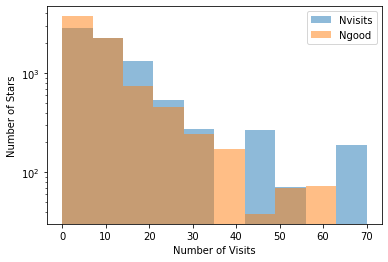

In [7]:
plt.hist(allStar_com_tab['nvisits'],10,(0,70),alpha=.5,label='Nvisits')
plt.hist(allStar_com_tab['ngoodvisits'],10,(0,70),alpha=.5,label='Ngood')
plt.xlabel('Number of Visits')
plt.ylabel("Number of Stars")
plt.yscale('log')
plt.legend()
plt.show()

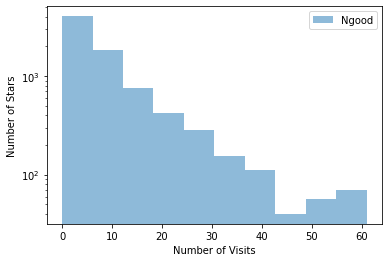

In [8]:
plt.hist(allStar_com_tab['ngoodrvs'],alpha=.5,label='Ngood')
plt.xlabel('Number of Visits')
plt.ylabel("Number of Stars")
plt.yscale('log')
plt.legend()
plt.show()

In [9]:
allVisit_com_tab = allVisit_tab[allVisit_tab['mjd'] > 59550]
allVisit_plate_tab = allVisit_tab[allVisit_tab['mjd'] < 59550]
allVisit_com_tab

apogee_id,target_id,apred_vers,file,uri,fiberid,plate,mjd,telescope,survey,field,programname,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,pmra,pmdec,pm_src,apogee_target1,apogee_target2,apogee_target3,apogee_target4,catalogid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,snr,starflag,starflags,dateobs,jd,starver,bc,vtype,vrel,vrelerr,vheliobary,chisq,rv_teff,rv_feh,rv_logg,xcorr_vrel,xcorr_vrelerr,xcorr_vheliobary,n_components,rv_components [3]
bytes28,bytes28,bytes15,bytes51,bytes126,int64,bytes15,int64,bytes16,bytes23,bytes32,bytes38,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,float32,int64,bytes79,bytes33,float64,bytes15,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64
,,daily,apVisit-daily-apo25m-152-59562-064.fits,apogee/spectro/redux/daily/visit/apo25m/16056/152/59562/apVisit-daily-apo25m-152-59562-064.fits,64,152,59562,apo25m,SDSS-V,16056,manual_fps_position_stars,91.0477938395,60.0770590309,153.76812566326524,17.717603906939722,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,-1,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,9.20846,0,,2021-12-14T10:21:21.150,2459562.98253,,-999999.0,-9999,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-9999,nan .. nan
,,daily,apVisit-daily-apo25m-152-59562-063.fits,apogee/spectro/redux/daily/visit/apo25m/16056/152/59562/apVisit-daily-apo25m-152-59562-063.fits,63,152,59562,apo25m,SDSS-V,16056,manual_fps_position_stars,90.6554344244,60.2210444071,153.54672666305808,17.59775306109105,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,-1,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,9.05342,0,,2021-12-14T10:21:21.150,2459562.98253,,-999999.0,-9999,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-9999,nan .. nan
,,daily,apVisit-daily-apo25m-152-59562-062.fits,apogee/spectro/redux/daily/visit/apo25m/16056/152/59562/apVisit-daily-apo25m-152-59562-062.fits,62,152,59562,apo25m,SDSS-V,16056,manual_fps_position_stars,91.5475854408,60.2941743338,153.66378012499968,18.0322851906306,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,-1,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,9.41438,0,,2021-12-14T10:21:21.150,2459562.98253,,-999999.0,-9999,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-9999,nan .. nan
,,daily,apVisit-daily-apo25m-152-59562-061.fits,apogee/spectro/redux/daily/visit/apo25m/16056/152/59562/apVisit-daily-apo25m-152-59562-061.fits,61,152,59562,apo25m,SDSS-V,16056,manual_fps_position_stars,90.9688108521,60.1136586191,153.71625771021058,17.696421092659982,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,-1,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,7.40536,0,,2021-12-14T10:21:21.150,2459562.98253,,-999999.0,-9999,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-9999,nan .. nan
,,daily,apVisit-daily-apo25m-152-59562-060.fits,apogee/spectro/redux/daily/visit/apo25m/16056/152/59562/apVisit-daily-apo25m-152-59562-060.fits,60,152,59562,apo25m,SDSS-V,16056,manual_fps_position_stars,91.8878388108,60.6598401553,153.3795697340178,18.330466298146835,-9999.99,-9999.99,-9999.99,-9999.99,-99

## Let's Look at Design 12798
Field 19092 configuraiton 2649

In [10]:
allVisit_sm_tab = allVisit_com_tab[np.array(allVisit_com_tab['field'],dtype='int64') == 19092]
allVisit_sm_tab

apogee_id,target_id,apred_vers,file,uri,fiberid,plate,mjd,telescope,survey,field,programname,ra,dec,glon,glat,jmag,jerr,hmag,herr,kmag,kerr,src_h,pmra,pmdec,pm_src,apogee_target1,apogee_target2,apogee_target3,apogee_target4,catalogid,gaiadr2_plx,gaiadr2_plx_error,gaiadr2_pmra,gaiadr2_pmra_error,gaiadr2_pmdec,gaiadr2_pmdec_error,gaiadr2_gmag,gaiadr2_gerr,gaiadr2_bpmag,gaiadr2_bperr,gaiadr2_rpmag,gaiadr2_rperr,sdssv_apogee_target0,firstcarton,targflags,snr,starflag,starflags,dateobs,jd,starver,bc,vtype,vrel,vrelerr,vheliobary,chisq,rv_teff,rv_feh,rv_logg,xcorr_vrel,xcorr_vrelerr,xcorr_vheliobary,n_components,rv_components [3]
bytes28,bytes28,bytes15,bytes51,bytes126,int64,bytes15,int64,bytes16,bytes23,bytes32,bytes38,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,bytes15,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes38,bytes113,float32,int64,bytes79,bytes33,float64,bytes15,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64
,,daily,apVisit-daily-apo25m-2649-59602-061.fits,apogee/spectro/redux/daily/visit/apo25m/19092/2649/59602/apVisit-daily-apo25m-2649-59602-061.fits,61,2649,59602,apo25m,SDSS-V,19092,bhm_csc_apogee,124.553504162,47.302938135,172.34552886125695,33.93262427120182,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,-999,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,0.261266,4112,"LOW_SNR,PERSIST_JUMP_POS",2022-01-23T07:11:47.697,2459602.83328,,-999999.0,-9999,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-9999,nan .. nan
,,daily,apVisit-daily-apo25m-2649-59602-014.fits,apogee/spectro/redux/daily/visit/apo25m/19092/2649/59602/apVisit-daily-apo25m-2649-59602-014.fits,14,2649,59602,apo25m,SDSS-V,19092,bhm_csc_apogee,124.065868643,47.4603460038,172.1237265507812,33.61670315667847,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,-999,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,0.814084,14352,"LOW_SNR,PERSIST_LOW,PERSIST_JUMP_POS,PERSIST_JUMP_NEG",2022-01-23T07:11:47.697,2459602.83328,,-999999.0,-9999,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-9999,nan .. nan
,,daily,apVisit-daily-apo25m-2649-59602-012.fits,apogee/spectro/redux/daily/visit/apo25m/19092/2649/59602/apVisit-daily-apo25m-2649-59602-012.fits,12,2649,59602,apo25m,SDSS-V,19092,bhm_csc_apogee,125.038994461,48.051317444,171.47315921442473,34.3139204476071,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,-999,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,1.16537,14352,"LOW_SNR,PERSIST_LOW,PERSIST_JUMP_POS,PERSIST_JUMP_NEG",2022-01-23T07:11:47.697,2459602.83328,,-999999.0,-9999,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-9999,nan .. nan
,,daily,apVisit-daily-apo25m-2649-59602-009.fits,apogee/spectro/redux/daily/visit/apo25m/19092/2649/59602/apVisit-daily-apo25m-2649-59602-009.fits,9,2649,59602,apo25m,SDSS-V,19092,bhm_csc_apogee,124.116111901,47.9459863167,171.5456252670635,33.690348234339424,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,,0.0,0.0,,0,0,0,0,-999,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,0,,,1.20079,14352,"LOW_SNR,PERSIST_LOW,PERSIST_JUMP_POS,PERSIST_JUMP_NEG",2022-01-23T07:11:47.697,2459602.83328,,-999999.0,-9999,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-9999,nan .. nan
,,daily,apVisit-daily-apo25m-2649-59602-008.fits,apogee/spectro/redux/daily/visit/apo25m/19092/2649/59602/apVisit-daily-apo25

In [11]:
np.unique(allVisit_sm_tab['mjd']) #Only one MJD so far

59602


## Since there is only one observation of 12798, I am stuck for the moment. Below is an example of the kind of analysis I would like to do.
This example uses a merge table produced by Nick Troup. In this case for DR17. I can do the same thing with the allVisit table, it is just easier to use the merge table for this example.

In [12]:
merge_tab = Table.read('allStarMerge-dr17-synspec.fits')
merge_tab

APOGEE_ID,NVISITS,NENTRIES,RA,DEC,GLON,GLAT,PMRA,PMDEC,PM_SRC,J,J_ERR,H,H_ERR,K,K_ERR,AK,VHELIO_AVG,VHELIO_ERR,VSCATTER,SIG_RVVAR,BASELINE,MEAN_FIBER,SIG_FIBER,STARS_PK,NVISITS_ENTRY,SNR_ENTRY,TELESCOPES,FIELDS,SURVEYS,PROGRAMNAMES,LOCATION_IDS,TARGFLAGS,STARFLAGS,ASPCAPFLAGS,MEMBER,GAIA_SOURCE_ID,DIST,DIST_ERR,DIST_SRC,TEFF_AVG,TEFF_AVG_ERR,LOGG_AVG,LOGG_AVG_ERR,M_H_AVG,M_H_AVG_ERR,VISITS_PK,JD,RV,RV_ERR,RV_FLAG,VISIT_SNR,FIBERID
bytes19,int16,int32,float64,float64,float64,float64,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes125,bytes35,bytes143,bytes125,bytes197,bytes251,bytes108,bytes89,bytes294,bytes147,bytes212,bytes9,int64,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,bytes775,bytes969,bytes987,bytes1124,bytes457,bytes775,bytes374
19140272-1554055,1,1,288.5113798,-15.9017081,21.090734580355388,-12.077119072434481,-0.4556614,-26.357784,GaiaEDR3,99.999,0.0,5.75,0.0,99.999,0.0,nan,26.439007,0.027253453,nan,nan,0.0,229.0,nan,630459,1,155.092,apo1m,ruprecht147,apo1m,,1,APOGEE_1MTARGETAPOGEE2_1M_TARGET,,,,4184200643505162112,302.62424,4.376603,GaiaEDR3,4593.4307,8.196055,2.5725074,0.023374118,0.049885,0.0069118906,2290397,2458402.6,26.439007,0.027253453,0,110.095,229
19155129-1617591,1,1,288.9637384,-16.2998544,20.909359279525887,-12.639275557729611,-0.8129271,-26.953403,GaiaEDR3,99.999,0.0,5.94,0.0,99.999,0.0,nan,41.02357,0.029602379,nan,nan,0.0,229.0,nan,632244,1,90.4986,apo1m,ruprecht147,apo1m,,1,APOGEE_1MTARGETAPOGEE2_1M_TARGET,,,,4184125807991900928,305.0827,2.0925505,GaiaEDR3,4805.956,13.134305,2.6050694,0.029080683,0.083448,0.008831771,2296599,2458402.6,41.023571,0.029602379,0,59.5144,229
19170343-1703138,1,1,289.2642889,-17.0539368,20.33102110865589,-13.217030426494304,-1.3733565,-26.559818,GaiaEDR3,99.999,0.0,5.93,0.0,99.999,0.0,nan,41.670525,0.034340605,nan,nan,0.0,229.0,nan,633428,1,70.2426,apo1m,ruprecht147,apo1m,,1,APOGEE_1MTARGETAPOGEE2_1M_TARGET,,,,4087762031955829120,308.99887,3.6773474,GaiaEDR3,4816.8867,14.5755415,2.6481612,0.030921528,0.10221,0.009593967,2300718,2458421.6,41.670525,0.034340605,0,49.1181,229
19171130-1603082,1,1,289.297128,-16.0524017,21.277714815945416,-12.825447521426172,-0.8349858,-27.168303,GaiaEDR3,99.999,0.0,5.8,0.0,99.999,0.0,nan,41.559208,0.06636003,nan,nan,0.0,229.0,nan,633569,1,22.9800,apo1m,ruprecht147,apo1m,,1,APOGEE_1MTARGETAPOGEE2_1M_TARGET,,SN_BAD,,4184137077986034048,313.08777,2.5029533,GaiaEDR3,4779.1113,35.376545,2.4609113,0.06037963,0.094433,0.019543542,2301198,2458421.6,41.559208,0.066360027,0,14.6920,229
19180978-1616222,2,1,289.5407614,-16.272986,21.173277014696026,-13.130501685824605,-1.2853795,-27.21475,GaiaEDR3,99.999,0.0,6.02,0.0,99.999,0.0,nan,41.73818,0.024838435,0.02883967,0.83573985,1.99663,229.0,0.0,634526,2,80.1555,apo1m,ruprecht147,apo1m,,1,APOGEE_1MTARGETAPOGEE2_1M_TARGET,,,,4183930438518525184,298.16382,1.9328821,GaiaEDR3,4787.643,13.512836,2.6136408,0.029247312,0.16087,0.009076576,"2304422,2304423","2458426.6,2458424.6","41.758571,41.717785","0.038718654,0.031123255","0,0","36.5519,38.1370","229,229"
2M00000002+7417074,3,1,0.000103,74.285408,119.40180722431822,11.767413541486242,0.04858199,0.5222485,GaiaEDR3,8.597,0.039,7.667,0.029,7.314,0.018,0.24235167,-51.726097,0.011924585,0.20453316,9.710826,37.90377,23.333334,30.17173,1,3,827.156,apo25m,120+12,apogee2,disk,5046,"APOGEE2_NORMAL_SAMPLE,APOGEE2_SHORT,APOGEE2_TWOBIN_GT_0_8,APOGEE2_WISE_DERED","PERSIST_LOW,PERSIST_MED",,,538028216707715712,3503.3428,239.02469,GaiaEDR3,3723.9111,4.0603027,0.9045983,0.021523084,-0.14768,0.0071834084,"2,3,4","2456936.8,2456971.7,2456933.8","-51.544378,-51.947600,-51.686318","0.021745438,0.020773587,0.019374099","0,0,0","368.172,402.049,399.367","3,58,9"
2M00000019-1924498,3,1,0.000832,-19.413851,63.39412165971994,-75.90639677002453,20.290022,-10.34126,GaiaEDR3,11.074,0.022,10.74,0.026,10.67,0.023,0.006158138,19.07629,0.022642815,0.08796514,2.3800595,1091.004

## Generate median Visit S/N

In [13]:
med_snr_list = list()
merge_tab['VISIT_SNR'][(merge_tab['APOGEE_ID']=='2M17240000-1449481 ')] = 'nan'
for row in merge_tab:
    try:
        visit_arr = np.array([float(x) for x in row['VISIT_SNR'].split(',')])
    except:
        print(row['APOGEE_ID'],row['VISIT_SNR'])
    med_snr = np.median(visit_arr)
    med_snr_list.append(med_snr)
merge_tab['VISIT_MED_SNR'] = med_snr_list

## Limit to stars with 3 visits

In [14]:
merge3_tab = merge_tab[(merge_tab['NVISITS'] == 3)]
merge3_tab[0:10]

APOGEE_ID,NVISITS,NENTRIES,RA,DEC,GLON,GLAT,PMRA,PMDEC,PM_SRC,J,J_ERR,H,H_ERR,K,K_ERR,AK,VHELIO_AVG,VHELIO_ERR,VSCATTER,SIG_RVVAR,BASELINE,MEAN_FIBER,SIG_FIBER,STARS_PK,NVISITS_ENTRY,SNR_ENTRY,TELESCOPES,FIELDS,SURVEYS,PROGRAMNAMES,LOCATION_IDS,TARGFLAGS,STARFLAGS,ASPCAPFLAGS,MEMBER,GAIA_SOURCE_ID,DIST,DIST_ERR,DIST_SRC,TEFF_AVG,TEFF_AVG_ERR,LOGG_AVG,LOGG_AVG_ERR,M_H_AVG,M_H_AVG_ERR,VISITS_PK,JD,RV,RV_ERR,RV_FLAG,VISIT_SNR,FIBERID,VISIT_MED_SNR
bytes19,int16,int32,float64,float64,float64,float64,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes125,bytes35,bytes143,bytes125,bytes197,bytes251,bytes108,bytes89,bytes294,bytes147,bytes212,bytes9,int64,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,bytes775,bytes969,bytes987,bytes1124,bytes457,bytes775,bytes374,float64
2M00000002+7417074,3,1,0.000103,74.285408,119.40180722431822,11.767413541486242,0.04858199,0.5222485,GaiaEDR3,8.597,0.039,7.667,0.029,7.314,0.018,0.24235167,-51.726097,0.011924585,0.20453316,9.710826,37.90377,23.333334,30.17173,1,3,827.156,apo25m,120+12,apogee2,disk,5046,"APOGEE2_NORMAL_SAMPLE,APOGEE2_SHORT,APOGEE2_TWOBIN_GT_0_8,APOGEE2_WISE_DERED","PERSIST_LOW,PERSIST_MED",,,538028216707715712,3503.3428,239.02469,GaiaEDR3,3723.9111,4.0603027,0.9045983,0.021523084,-0.14768,0.0071834084,"2,3,4","2456936.8,2456971.7,2456933.8","-51.544378,-51.947600,-51.686318","0.021745438,0.020773587,0.019374099","0,0,0","368.172,402.049,399.367","3,58,9",399.367
2M00000019-1924498,3,1,0.000832,-19.413851,63.39412165971994,-75.90639677002453,20.290022,-10.34126,GaiaEDR3,11.074,0.022,10.74,0.026,10.67,0.023,0.006158138,19.07629,0.022642815,0.08796514,2.3800595,1091.0048,166.0,0.0,2,3,229.875,apo25m,060-75,apogee2,halo,5071,"APOGEE2_NORMAL_SAMPLE,APOGEE2_ONEBIN_GT_0_3,APOGEE2_SFD_DERED,APOGEE2_SHORT",,"N_M_WARN,VMICRO_WARN",,2413929812587459072,nan,nan,,5501.773,25.553564,4.304115,0.024554765,-0.26875,0.00675281,"5,6,7","2458037.7,2457293.8,2458384.8","19.166855,18.991178,19.070838","0.038799648,0.034874772,0.043504155","0,0,0","91.6308,100.110,80.5261","166,166,166",91.6308
2M00000068+5710233,3,1,0.00285,57.173164,115.97715352490295,-5.002392369725437,5.7917247,-12.735589,GaiaEDR3,10.664,0.023,10.132,0.03,10.018,0.02,0.0055077374,-12.678677,0.017064659,0.1202452,4.419973,776.88495,264.0,4.582576,6,3,294.876,apo25m,N7789,apogee,apogee,4264,APOGEE_SHORT,,,,421077597267551104,721.3156,9.140148,GaiaEDR3,5031.2637,10.145057,3.456132,0.023554068,-0.16008,0.0060127303,"26,27,28","2455874.7,2456643.6,2456651.6","-12.813488,-12.640052,-12.582490","0.027667521,0.034766040,0.025429396","0,0,0","117.223,120.336,134.909","263,269,260",120.336
2M00000233+1452324,3,1,0.009748,14.875667,104.84553001173448,-46.18315758221248,-28.312918,-62.417347,GaiaEDR3,10.649,0.022,10.131,0.028,10.04,0.023,0.012376556,-38.503563,0.01736453,0.053983662,1.4474314,28.95201,115.666664,27.135462,11,3,203.344,apo25m,105-45,apogee,apogee,4548,"APOGEE_SFD_DERED,APOGEE_SHORT",PERSIST_LOW,VSINI_WARN,,2771993642553377280,218.94116,9.908165,GaiaEDR3,4784.1167,10.28097,4.5366573,0.01325069,0.33274,0.0044405824,"46,47,48","2456588.7,2456613.7,2456584.7","-38.465491,-38.565343,-38.479852","0.026961055,0.038896896,0.021768670","0,0,0","106.849,74.1304,132.312","100,147,100",106.849
2M00000317+5821383,3,1,0.013232,58.360649,116.2190793640249,-3.8396474428727374,-4.353479,-1.2594347,GaiaEDR3,8.206,0.021,7.279,0.027,6.946,0.021,0.23867993,-79.781845,0.012146088,0.0788175,3.3000968,26.94351,55.666668,3.2145503,12,3,638.673,apo25m,116-04,apogee,apogee,4424,APOGEE_SHORT,PERSIST_HIGH,,,422737314373993984,2778.9211,152.11203,GaiaEDR3,3889.287,4.682571,0.9987238,0.02306676,-0.27749,0.0074086464,"49,50,51","2456261.6,2456284.6,2456257.6","-79.751997,-79.871224,-79.722306","0.017350608,0.024547087,0.020594758","0,0,0","576.325,396.397,490.552","57,52,58",490.552
2M00000446+5854329,3,1,0.018603,58.909149,116.33076130431827,-3.3025

## Limit to only high quality stars

In [15]:
#Steal good flag from first star that has them
good_star_flag = merge3_tab['STARFLAGS'][2]
good_ascap_flag = merge3_tab['ASPCAPFLAGS'][2]
good_rv_flag = merge3_tab['RV_FLAG'][2]

In [16]:
good3_tab = merge3_tab[(merge3_tab['STARFLAGS'] == good_star_flag) & 
                       (merge3_tab['ASPCAPFLAGS'] == good_ascap_flag) &
                      (merge3_tab['RV_FLAG'] == good_rv_flag)]
good3_tab[0:10]

APOGEE_ID,NVISITS,NENTRIES,RA,DEC,GLON,GLAT,PMRA,PMDEC,PM_SRC,J,J_ERR,H,H_ERR,K,K_ERR,AK,VHELIO_AVG,VHELIO_ERR,VSCATTER,SIG_RVVAR,BASELINE,MEAN_FIBER,SIG_FIBER,STARS_PK,NVISITS_ENTRY,SNR_ENTRY,TELESCOPES,FIELDS,SURVEYS,PROGRAMNAMES,LOCATION_IDS,TARGFLAGS,STARFLAGS,ASPCAPFLAGS,MEMBER,GAIA_SOURCE_ID,DIST,DIST_ERR,DIST_SRC,TEFF_AVG,TEFF_AVG_ERR,LOGG_AVG,LOGG_AVG_ERR,M_H_AVG,M_H_AVG_ERR,VISITS_PK,JD,RV,RV_ERR,RV_FLAG,VISIT_SNR,FIBERID,VISIT_MED_SNR
bytes19,int16,int32,float64,float64,float64,float64,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes125,bytes35,bytes143,bytes125,bytes197,bytes251,bytes108,bytes89,bytes294,bytes147,bytes212,bytes9,int64,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,bytes775,bytes969,bytes987,bytes1124,bytes457,bytes775,bytes374,float64
2M00000068+5710233,3,1,0.00285,57.173164,115.97715352490295,-5.002392369725437,5.7917247,-12.735589,GaiaEDR3,10.664,0.023,10.132,0.03,10.018,0.02,0.0055077374,-12.678677,0.017064659,0.1202452,4.419973,776.88495,264.0,4.582576,6,3,294.876,apo25m,N7789,apogee,apogee,4264,APOGEE_SHORT,,,,421077597267551104,721.3156,9.140148,GaiaEDR3,5031.2637,10.145057,3.456132,0.023554068,-0.16008,0.0060127303,"26,27,28","2455874.7,2456643.6,2456651.6","-12.813488,-12.640052,-12.582490","0.027667521,0.034766040,0.025429396","0,0,0","117.223,120.336,134.909","263,269,260",120.336
2M00000446+5854329,3,1,0.018603,58.909149,116.33076130431827,-3.302584807063638,-2.2376974,-1.1798049,GaiaEDR3,12.255,0.023,11.489,0.027,11.241,0.022,0.27540034,-48.04777,0.025997162,0.031308003,1.1711189,26.94351,222.0,53.777317,13,3,137.320,apo25m,116-04,apogee,apogee,4424,APOGEE_SHORT,,,,422775384964691328,4639.1255,459.10278,GaiaEDR3,4766.6274,10.474075,2.420902,0.026512047,-0.075324,0.0076422007,"52,53,54","2456257.6,2456284.6,2456261.6","-48.016733,-48.047236,-48.079343","0.025565184,0.068177979,0.027943802","0,0,0","71.0113,26.8262,65.7128","194,284,188",65.7128
2M00000546+6152107,3,1,0.022759,61.869644,116.91899203295556,-0.40103846766326556,1.9954104,1.3530527,GaiaEDR3,9.013,0.063,8.029,0.057,7.745,0.02,0.2726461,-33.45392,0.011826571,0.0584893,3.213819,53.81138,78.0,3.4641016,19,3,822.305,apo25m,116+00,apogee2,disk2,5045,"APOGEE2_NORMAL_SAMPLE,APOGEE2_SHORT,APOGEE2_TWOBIN_GT_0_8,APOGEE2_WISE_DERED",,,,429530195985183744,2736.772,115.374,GaiaEDR3,4073.77,5.285125,1.2815037,0.02325482,-0.27033,0.0072073503,"68,69,70","2456938.7,2456944.7,2456992.6","-33.423213,-33.521364,-33.417173","0.023688979,0.018168488,0.019171549","0,0,0","303.728,389.288,371.574","82,76,76",371.574
2M00000866+7122144,3,1,0.036099,71.370689,118.81652209689801,8.91009664329906,-7.606874,-2.3033931,GaiaEDR3,9.795,0.023,9.057,0.027,8.872,0.023,0.14779836,-16.715317,0.013382411,0.023486933,1.0831838,27.90299,222.0,3.4641016,28,3,457.770,apo25m,120+08,apogee,apogee,4120,"APOGEE_SHORT,APOGEE_WISE_DERED",,,,531274466534134272,1113.241,12.2627535,GaiaEDR3,4669.081,7.625217,2.52728,0.022585828,-0.12412,0.0062629203,"110,111,112","2456258.6,2456262.6,2456234.7","-16.694854,-16.740962,-16.710135","0.024904257,0.020654791,0.023768844","0,0,0","174.447,212.804,185.388","226,220,220",185.388
2M00001199+6114138,3,1,0.049987,61.237167,116.80675589625501,-1.023614722359749,0.030946061,2.0629132,GaiaEDR3,10.702,0.026,10.022,0.032,9.842,0.021,0.17992827,-47.306828,0.012728752,0.020443644,0.86468244,29.93287,93.666664,31.469563,35,3,347.048,apo25m,116+00,apogee2,disk2,5045,"APOGEE2_NORMAL_SAMPLE,APOGEE2_SHORT,APOGEE2_TWOBIN_0_5_TO_0_8,APOGEE2_WISE_DERED",,,,429484398762416384,1727.2692,40.595325,GaiaEDR3,4660.645,7.267649,2.3938954,0.020884167,0.046961,0.005846905,"144,145,146","2457292.8,2457262.9,2457265.9","-47.283262,-47.317401,-47.319818","0.023691056,0.019791895,0.022476763","0,0,0","139.733,162.666,142.504","75,130,76",142.504
2M00001296+5851378,3,1,0.054009,58.8605,116.33908431103268,-3.3538922120961128,3.9131792,1.8032084,GaiaEDR

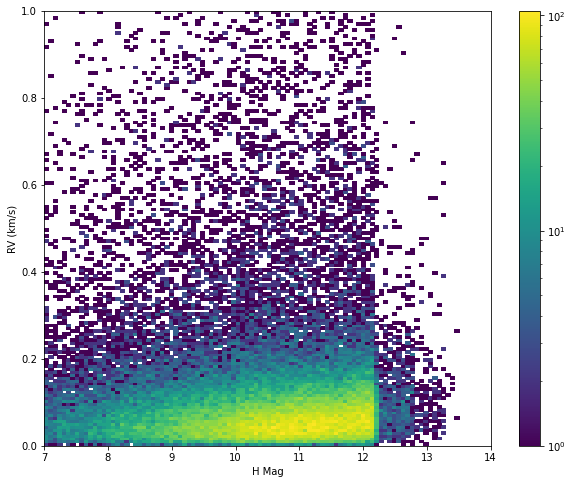

In [17]:
plt.figure(figsize=(10,8))
plt.hist2d(good3_tab['H'],good3_tab['VSCATTER'],bins=(100,150),range=((7,14),(0,1.0)),
           norm=mpl.colors.LogNorm())
plt.xlabel("H Mag")
plt.ylabel("RV (km/s)")
#plt.yscale('log')
#plt.cscale('log')
plt.colorbar()
plt.show()

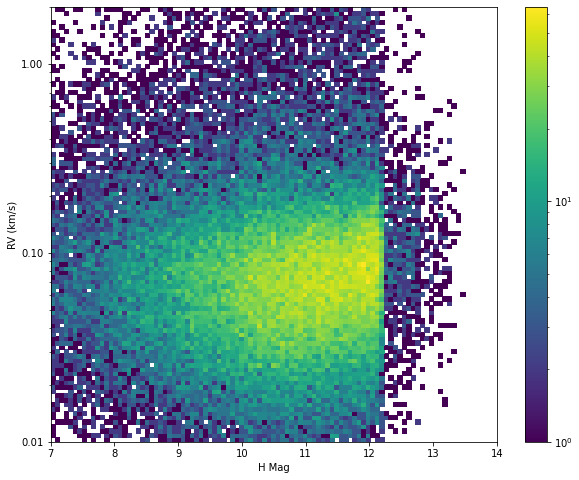

In [18]:
plt.figure(figsize=(10,8))
xbins = np.linspace(7, 14, 100)
ybins = 10**np.linspace(-2, .3, 100)
counts, _, _ = np.histogram2d(good3_tab['H'],good3_tab['VSCATTER'],bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
plt.xlabel("H Mag")
plt.ylabel("RV (km/s)")
plt.yscale('log')
plt.colorbar()
plt.ylim(0.01,2)
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.show()

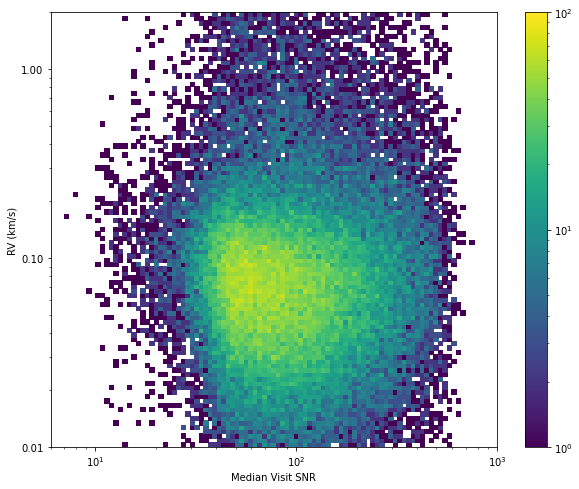

In [19]:
plt.figure(figsize=(10,8))
xbins = 10**np.linspace(np.log10(6), 3, 100)
ybins = 10**np.linspace(-2,np.log10(2), 100)
counts, _, _ = np.histogram2d(good3_tab['VISIT_MED_SNR'],good3_tab['VSCATTER'],bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
plt.xlabel("Median Visit SNR")
plt.ylabel("RV (km/s)")
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.ylim(0.01,2)
plt.clim(1,100)
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.show()

## Reproduce David's plot

In [20]:
david_tab = merge_tab[(merge_tab['TEFF_AVG'] > 4000) & (merge_tab['TEFF_AVG'] < 4500) & (merge_tab['NVISITS'] >= 3) ]
david_tab

APOGEE_ID,NVISITS,NENTRIES,RA,DEC,GLON,GLAT,PMRA,PMDEC,PM_SRC,J,J_ERR,H,H_ERR,K,K_ERR,AK,VHELIO_AVG,VHELIO_ERR,VSCATTER,SIG_RVVAR,BASELINE,MEAN_FIBER,SIG_FIBER,STARS_PK,NVISITS_ENTRY,SNR_ENTRY,TELESCOPES,FIELDS,SURVEYS,PROGRAMNAMES,LOCATION_IDS,TARGFLAGS,STARFLAGS,ASPCAPFLAGS,MEMBER,GAIA_SOURCE_ID,DIST,DIST_ERR,DIST_SRC,TEFF_AVG,TEFF_AVG_ERR,LOGG_AVG,LOGG_AVG_ERR,M_H_AVG,M_H_AVG_ERR,VISITS_PK,JD,RV,RV_ERR,RV_FLAG,VISIT_SNR,FIBERID,VISIT_MED_SNR
bytes19,int16,int32,float64,float64,float64,float64,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes125,bytes35,bytes143,bytes125,bytes197,bytes251,bytes108,bytes89,bytes294,bytes147,bytes212,bytes9,int64,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,bytes775,bytes969,bytes987,bytes1124,bytes457,bytes775,bytes374,float64
2M00000546+6152107,3,1,0.022759,61.869644,116.91899203295556,-0.40103846766326556,1.9954104,1.3530527,GaiaEDR3,9.013,0.063,8.029,0.057,7.745,0.02,0.2726461,-33.45392,0.011826571,0.0584893,3.213819,53.81138,78.0,3.4641016,19,3,822.305,apo25m,116+00,apogee2,disk2,5045,"APOGEE2_NORMAL_SAMPLE,APOGEE2_SHORT,APOGEE2_TWOBIN_GT_0_8,APOGEE2_WISE_DERED",,,,429530195985183744,2736.772,115.374,GaiaEDR3,4073.77,5.285125,1.2815037,0.02325482,-0.27033,0.0072073503,"68,69,70","2456938.7,2456944.7,2456992.6","-33.423213,-33.521364,-33.417173","0.023688979,0.018168488,0.019171549","0,0,0","303.728,389.288,371.574","82,76,76",371.574
2M00000717-7213573,12,1,0.029898,-72.232605,308.3693311961797,-44.34980629032347,0.33229935,-1.422818,GaiaEDR3,15.187,0.049,14.516,0.064,14.492,0.096,0.009895852,135.76009,nan,0.5728506,1.639706,18.90312,63.75,1.544786,24,6,30.2005,lco25m,SMC12,apogee2s,magclouds,7218,"APOGEE2_GAIA_OVERLAP,APOGEE2_MAGCLOUD_CANDIDATE",,VMICRO_WARN,,4701763512829847808,-40286.145,82982.46,GaiaEDR3,4463.1123,18.685774,2.1463056,0.08712692,-1.157,0.023981659,"86,87,88,89,90,91,92,93,94,95,96,97","2459160.6,2459164.5,2459155.6,2459154.6,2459158.6,2459166.5,2459157.6,2459156.6,2459147.6,2459165.5,2459162.6,2459159.6","135.37064,NaN,NaN,NaN,135.48374,135.84694,NaN,NaN,NaN,136.85191,135.70566,135.30164","0.36840336,NaN,NaN,NaN,0.43637001,0.32033683,NaN,NaN,NaN,0.34300950,0.36211661,0.40164214","1,0,0,0,1,1,0,0,0,1,1,1","8.74923,11.1361,10.8581,10.8076,7.13712,9.84927,10.7854,10.7855,9.15007,9.24006,8.87105,8.04026","65,65,62,62,65,65,62,62,62,65,65,65",9.544665
2M00001649-7342309,12,1,0.068727,-73.708603,307.79794083664615,-42.9328549322749,0.26741827,-1.1660463,GaiaEDR3,15.315,0.046,14.829,0.071,14.676,0.114,nan,162.49338,0.07740275,0.2578112,0.93096495,18.90312,232.0,16.596825,50,12,48.0193,lco25m,SMC12,apogee2s,magclouds,7218,"APOGEE2_GAIA_OVERLAP,APOGEE2_MAGCLOUD_CANDIDATE",BRIGHT_NEIGHBOR,,,4689378643918560128,nan,nan,,4455.2236,17.441881,1.2632244,0.059900116,-1.243,0.019311788,"209,210,211,212,213,214,215,216,217,218,219,220","2459159.6,2459166.5,2459165.5,2459158.6,2459157.6,2459154.6,2459162.6,2459155.6,2459160.6,2459156.6,2459147.6,2459164.5","162.55156,162.08020,162.68396,162.30201,162.92262,162.60071,162.27657,162.29628,162.34942,162.51649,162.91384,162.42685","0.29425648,0.29839680,0.30545356,0.29003135,0.25178631,0.24481039,0.23282388,0.25505643,0.27721283,0.20895861,0.30997140,0.22472441","1,1,1,1,1,1,1,1,1,1,1,1","8.46597,8.63365,8.14097,8.16287,9.81102,10.1614,10.8051,9.83399,9.11797,11.6314,8.40611,11.5187","239,236,233,239,239,239,239,239,239,239,221,182",9.464495
2M00001653+5540107,4,1,0.068896,55.66964,115.71311887584872,-6.4832402573433745,-0.5524399,-2.036144,GaiaEDR3,11.337,0.024,10.544,0.031,10.354,0.023,0.09822558,-105.90228,0.011750204,0.04783808,2.3257623,22.90673,143.0,3.3665016,51,4,237.902,apo25m,N7789,apogee,apogee,4264,APOGEE_SHORT,,,,420520424055045248,6052.932,502.86368,GaiaEDR3,4148.1436,5.436856,1.592674,0.022477254,-0.18551,0.006893481,"221,222,223,224","2455821.8,2455844.7,2455824.8,2455843.7","-105.92955,-105.83338,-105.93904,-10

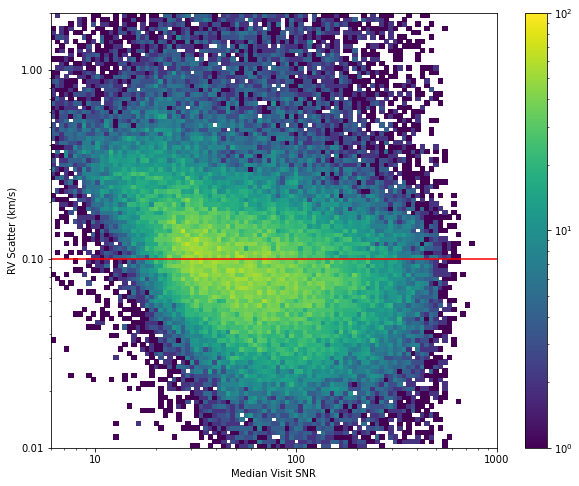

In [21]:
safe_snr_arr = david_tab['VISIT_MED_SNR'][np.isfinite(david_tab['VISIT_MED_SNR']) 
                                          & np.isfinite(david_tab['VSCATTER'])] 
safe_rms_arr = david_tab['VSCATTER'][np.isfinite(david_tab['VISIT_MED_SNR']) 
                                          & np.isfinite(david_tab['VSCATTER'])]

params = P.polyfit(safe_snr_arr,safe_rms_arr,9)

plt.figure(figsize=(10,8))
xbins = 10**np.linspace(np.log10(6), 3, 100)
ybins = 10**np.linspace(-2,np.log10(2), 100)
xp = np.linspace(10,200)

counts, _, _ = np.histogram2d(david_tab['VISIT_MED_SNR'],david_tab['VSCATTER'],bins=(xbins, ybins))

plt.pcolormesh(xbins, ybins, counts.T,norm=mpl.colors.LogNorm())
#plt.plot(xp,P.polyval(xp,params),c='r',lw=2)
plt.xlabel("Median Visit SNR")
plt.ylabel("RV Scatter (km/s)")
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.ylim(0.01,2)
plt.clim(1,100)
plt.gca().axhline(.1,c='r',label='100 m/s')
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.show()